# Adversarial Examples on CIFAR-10 (based on my MNIST notebook)

This notebook mirrors the MNIST notebook structure:
- Train a baseline CNN on CIFAR-10
- FGSM adversarial examples + evaluation + visualization
- Adversarial training using FGSM

**Note:** We use `ToTensor()` only (no mean/std normalization) so images stay in **[0,1]** and we can safely clamp adversarial images back to `[0,1]`.


In [1]:
import os
import random
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
from torchvision import datasets, transforms

ds = datasets.STL10(
    root="./data",
    split="train",
    download=False,
    transform=transforms.ToTensor()
)

x, y = ds[0]
print(x.shape)


torch.Size([3, 96, 96])


In [4]:
import os
print("cwd:", os.getcwd())
print("exists ./data?", os.path.exists("./data"))
print("exists ./data/stl10_binary?", os.path.exists("./data/stl10_binary"))
print("exists /data/stl10_binary?", os.path.exists("/data/stl10_binary"))


cwd: /home/hpc/b192aa/b192aa39
exists ./data? True
exists ./data/stl10_binary? True
exists /data/stl10_binary? False


In [5]:
import os

root = "./data/stl10_binary"
for f in os.listdir(root):
    path = os.path.join(root, f)
    print(f, os.path.getsize(path) / 1e6, "MB")


class_names.txt 5.5e-05 MB
unlabeled_X.bin 2764.8 MB
train_X.bin 138.24 MB
test_y.bin 0.008 MB
fold_indices.txt 0.047794 MB
test_X.bin 221.184 MB
train_y.bin 0.005 MB


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 96

transform = transforms.Compose([
    transforms.ToTensor(),   # keep [0,1]
])

train_ds = datasets.STL10(
    root="./data",
    split="train",
    download=False,
    transform=transform
)
print("done")
test_ds = datasets.STL10(
    root="./data",
    split="test",
    download=False,
    transform=transform
)
print("done")
train_loader = DataLoader(
    train_ds, batch_size=128, shuffle=True,
    num_workers=8, pin_memory=True
)
print("done")
test_loader = DataLoader(
    test_ds, batch_size=256, shuffle=False,
    num_workers=8, pin_memory=True
)
print("done")



done
done
done
done


/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.5.1/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
classes = train_ds.classes
print("Train:", len(train_ds), "Test:", len(test_ds))

Train: 5000 Test: 8000


x shape: torch.Size([128, 3, 96, 96])
y shape: torch.Size([128])
x dtype: torch.float32 y dtype: torch.int64
x min/max: 0.0 1.0


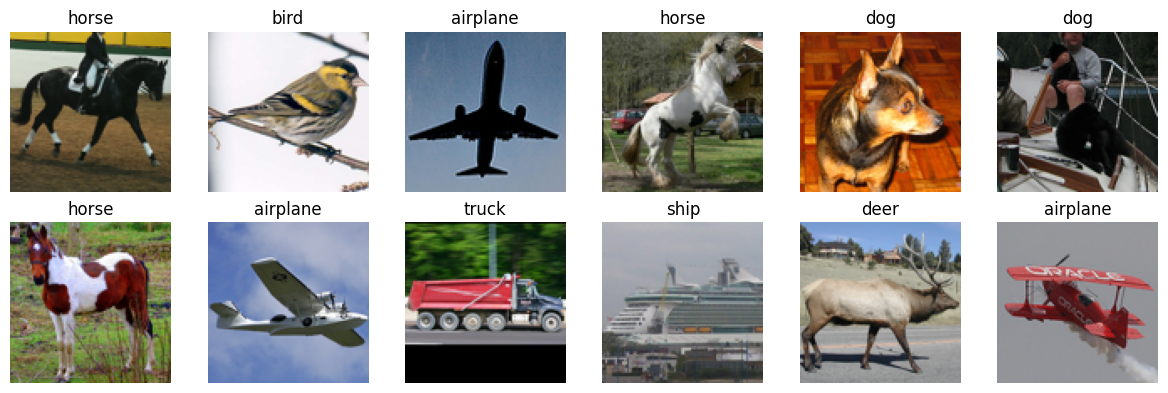

In [8]:
x, y = next(iter(train_loader))
print("x shape:", x.shape)  # (B, 3, 96, 96)
print("y shape:", y.shape)  # (B,)
print("x dtype:", x.dtype, "y dtype:", y.dtype)
print("x min/max:", x.min().item(), x.max().item())

classes = train_ds.classes
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for i, ax in enumerate(axes.flatten()):
    img = x[i].permute(1, 2, 0)  # (H,W,C) for matplotlib
    ax.imshow(img)
    ax.set_title(classes[y[i].item()])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [9]:
class SimpleCNN_STL10(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 96 -> 48

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 48 -> 24

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 24 -> 12
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 12 * 12, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN_STL10(num_classes=10).to(device)
print(model)


SimpleCNN_STL10(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
  

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])


In [10]:
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


In [11]:
EPOCHS = 30

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
best_model = None
best_acc = -1.0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    te_loss, te_acc = evaluate(model, test_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)

    if te_acc > best_acc:
        best_acc = te_acc
        best_model = deepcopy(model.state_dict())

    print(f"Epoch {epoch:02d} | "
          f"train loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"test loss={te_loss:.4f} acc={te_acc:.4f} | "
          f"best={best_acc:.4f}")

# load best
model.load_state_dict(best_model)
print("Loaded best model with test acc:", best_acc)


Epoch 01 | train loss=2.1654 acc=0.1879 | test loss=1.9616 acc=0.2606 | best=0.2606
Epoch 02 | train loss=1.8195 acc=0.3166 | test loss=1.6512 acc=0.3861 | best=0.3861
Epoch 03 | train loss=1.6427 acc=0.3816 | test loss=1.5677 acc=0.4187 | best=0.4187
Epoch 04 | train loss=1.5122 acc=0.4275 | test loss=1.5378 acc=0.4285 | best=0.4285
Epoch 05 | train loss=1.3918 acc=0.4859 | test loss=1.3745 acc=0.4821 | best=0.4821
Epoch 06 | train loss=1.2643 acc=0.5318 | test loss=1.3216 acc=0.5038 | best=0.5038
Epoch 07 | train loss=1.1523 acc=0.5689 | test loss=1.3582 acc=0.5087 | best=0.5087
Epoch 08 | train loss=1.0204 acc=0.6232 | test loss=1.3022 acc=0.5376 | best=0.5376
Epoch 09 | train loss=0.8493 acc=0.6879 | test loss=1.4801 acc=0.5199 | best=0.5376
Epoch 10 | train loss=0.7818 acc=0.7197 | test loss=1.4507 acc=0.5300 | best=0.5376
Epoch 11 | train loss=0.6094 acc=0.7836 | test loss=1.4466 acc=0.5527 | best=0.5527
Epoch 12 | train loss=0.4619 acc=0.8377 | test loss=1.5544 acc=0.5514 | best

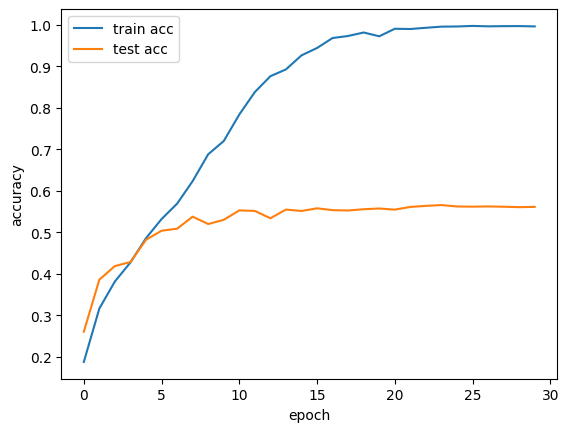

In [12]:
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["test_acc"], label="test acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [13]:
import torch

@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    all_preds, all_y = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu()
        all_preds.append(preds)
        all_y.append(y)
    return torch.cat(all_y), torch.cat(all_preds)

y_true, y_pred = get_preds(model, test_loader)
print("Test accuracy:", (y_true == y_pred).float().mean().item())


Test accuracy: 0.565625011920929


In [14]:
save_path = "stl10_best_model.pt"
torch.save(best_model, save_path)

print("Saved best model to:", save_path)


Saved best model to: stl10_best_model.pt


In [17]:
def fgsm_attack(model, x, y, epsilon):
    was_training = model.training
    model.eval()  # we want stable forward for the gradient step

    x_adv = x.detach().clone().to(device)
    x_adv.requires_grad_(True)
    y = y.to(device)

    logits = model(x_adv)
    loss = F.cross_entropy(logits, y)

    grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]
    x_adv = x_adv + epsilon * grad.sign()
    x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()

    if was_training:
        model.train()

    return x_adv



In [19]:
fgsm_model = SimpleCNN_STL10(num_classes=10).to(device)
fgsm_model.load_state_dict(best_model)
fgsm_model.eval()

def evaluate_fgsm(model, loader, epsilon):
    model.eval()
    total = 0
    correct_clean = 0
    correct_adv = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        total += x.size(0)

        with torch.no_grad():
            logits_clean = model(x)
        preds_clean = logits_clean.argmax(dim=1)
        correct_clean += (preds_clean == y).sum().item()

        x_adv = fgsm_attack(model, x, y, epsilon)
        with torch.no_grad():
            logits_adv = model(x_adv)
        preds_adv = logits_adv.argmax(dim=1)
        correct_adv += (preds_adv == y).sum().item()

    print(f"epsilon={epsilon:.5f} | clean acc={correct_clean/total:.4f} | FGSM acc={correct_adv/total:.4f}")

# CIFAR eps are usually expressed in “/255” terms
EPSILONS = [1/255, 2/255, 4/255, 8/255]

for eps in EPSILONS:
    evaluate_fgsm(fgsm_model, test_loader, eps)


epsilon=0.00392 | clean acc=0.5656 | FGSM acc=0.4104
epsilon=0.00784 | clean acc=0.5656 | FGSM acc=0.2933
epsilon=0.01569 | clean acc=0.5656 | FGSM acc=0.1550
epsilon=0.03137 | clean acc=0.5656 | FGSM acc=0.0808


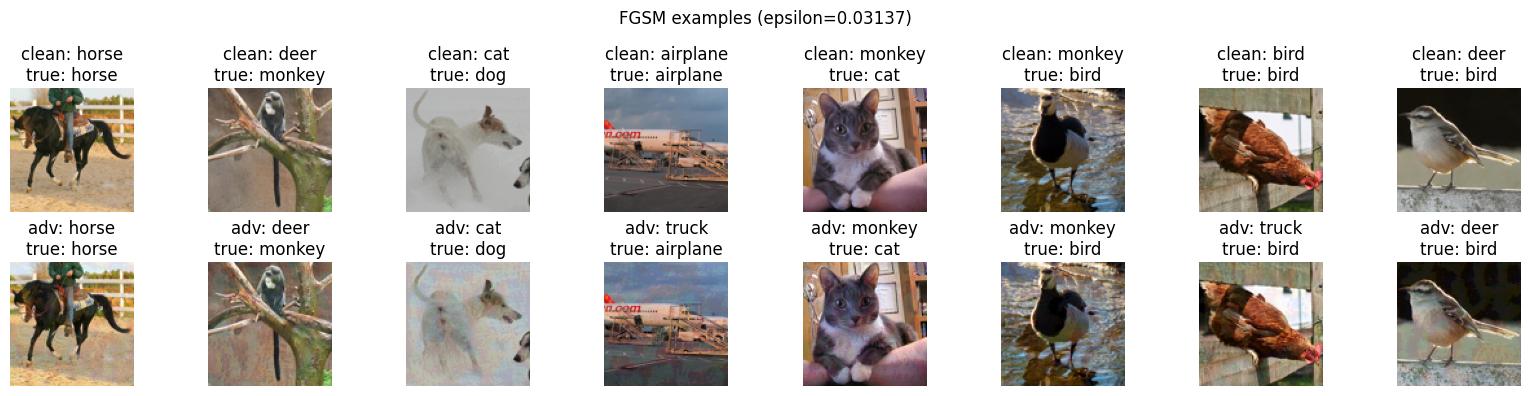

In [21]:
def show_adversarial_examples(model, loader, epsilon, n_examples=8):
    model.eval()
    x, y = next(iter(loader))
    x, y = x[:n_examples].to(device), y[:n_examples].to(device)

    x_adv = fgsm_attack(model, x, y, epsilon)

    with torch.no_grad():
        pred_clean = model(x).argmax(dim=1)
        pred_adv   = model(x_adv).argmax(dim=1)

    x_cpu, x_adv_cpu = x.cpu(), x_adv.cpu()
    y_cpu = y.cpu()
    pred_clean_cpu, pred_adv_cpu = pred_clean.cpu(), pred_adv.cpu()

    classes = train_ds.classes
    fig, axes = plt.subplots(2, n_examples, figsize=(2*n_examples, 4))
    for i in range(n_examples):
        axes[0, i].imshow(x_cpu[i].permute(1,2,0))
        axes[0, i].set_title(f"clean: {classes[pred_clean_cpu[i].item()]}\ntrue: {classes[y_cpu[i].item()]}")
        axes[0, i].axis("off")

        axes[1, i].imshow(x_adv_cpu[i].permute(1,2,0))
        axes[1, i].set_title(f"adv: {classes[pred_adv_cpu[i].item()]}\ntrue: {classes[y_cpu[i].item()]}")
        axes[1, i].axis("off")

    plt.suptitle(f"FGSM examples (epsilon={epsilon:.5f})")
    plt.tight_layout()
    plt.show()

show_adversarial_examples(fgsm_model, test_loader, epsilon=8/255)


In [22]:
def train_epoch_adv(model, loader, optimizer, epsilon=8/255, alpha=0.5):
    """
    loss = alpha * loss(clean) + (1-alpha) * loss(adversarial)
    """
    model.train()
    total_loss, total_correct = 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits_clean = model(x)
        loss_clean = F.cross_entropy(logits_clean, y)

        x_adv = fgsm_attack(model, x, y, epsilon)
        logits_adv = model(x_adv)
        loss_adv = F.cross_entropy(logits_adv, y)

        loss = alpha * loss_clean + (1 - alpha) * loss_adv

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits_clean.argmax(dim=1)
        total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc  = total_correct / len(loader.dataset)
    return avg_loss, avg_acc


In [25]:
LR = 3e-4
adv_model = SimpleCNN_STL10().to(device)
optimizer_adv = torch.optim.Adam(adv_model.parameters(), lr=LR)

EPOCHS_ADV = 12
EPSILON_TRAIN = 8/255
ALPHA = 0.5

for epoch in range(1, EPOCHS_ADV + 1):
    tr_loss, tr_acc = train_epoch_adv(adv_model, train_loader, optimizer_adv, epsilon=EPSILON_TRAIN, alpha=ALPHA)
    te_loss, te_acc = evaluate(adv_model, test_loader, criterion)

    print(f"[AdvTrain] Epoch {epoch:02d} | "
          f"train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"test loss={te_loss:.4f}, acc={te_acc:.4f}")


[AdvTrain] Epoch 01 | train loss=2.2193, acc=0.1848 | test loss=1.9609, acc=0.2804
[AdvTrain] Epoch 02 | train loss=1.9540, acc=0.3028 | test loss=1.7987, acc=0.2764
[AdvTrain] Epoch 03 | train loss=1.8550, acc=0.3588 | test loss=1.6771, acc=0.3726
[AdvTrain] Epoch 04 | train loss=1.7550, acc=0.4064 | test loss=1.5558, acc=0.4143
[AdvTrain] Epoch 05 | train loss=1.6687, acc=0.4524 | test loss=1.5131, acc=0.4257
[AdvTrain] Epoch 06 | train loss=1.5968, acc=0.4896 | test loss=1.4240, acc=0.4664
[AdvTrain] Epoch 07 | train loss=1.5306, acc=0.5228 | test loss=1.3843, acc=0.4895
[AdvTrain] Epoch 08 | train loss=1.4459, acc=0.5760 | test loss=1.3932, acc=0.4883
[AdvTrain] Epoch 09 | train loss=1.3805, acc=0.6156 | test loss=1.3768, acc=0.4792
[AdvTrain] Epoch 10 | train loss=1.2850, acc=0.6706 | test loss=1.3225, acc=0.5107
[AdvTrain] Epoch 11 | train loss=1.1551, acc=0.7278 | test loss=1.4142, acc=0.4904
[AdvTrain] Epoch 12 | train loss=1.0840, acc=0.7682 | test loss=1.3445, acc=0.5188


In [26]:
print("Baseline robustness:")
for eps in EPSILONS:
    evaluate_fgsm(fgsm_model, test_loader, eps)

print("\nAdv-trained robustness:")
for eps in EPSILONS:
    evaluate_fgsm(adv_model, test_loader, eps)


Baseline robustness:
epsilon=0.00392 | clean acc=0.5656 | FGSM acc=0.4104
epsilon=0.00784 | clean acc=0.5656 | FGSM acc=0.2933
epsilon=0.01569 | clean acc=0.5656 | FGSM acc=0.1550
epsilon=0.03137 | clean acc=0.5656 | FGSM acc=0.0808

Adv-trained robustness:
epsilon=0.00392 | clean acc=0.5196 | FGSM acc=0.4718
epsilon=0.00784 | clean acc=0.5196 | FGSM acc=0.4304
epsilon=0.01569 | clean acc=0.5196 | FGSM acc=0.3555
epsilon=0.03137 | clean acc=0.5196 | FGSM acc=0.2320


In [28]:


torch.save(adv_model.state_dict(),      "stl10_adv_trained_cnn.pt")

print("Models saved.")


Models saved.
